<a href="https://colab.research.google.com/github/Kryptera-K/XYZ-Elder-Style-Bull-Power-Volatility-Reversal-Strategy/blob/main/XYZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "XYZ"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("XYZ_clean.csv", index=False)
df

/tmp/ipython-input-3442573901.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2015-11-19,13.070000,14.780000,9.000000,11.200000,47466100
2015-11-20,12.850000,14.050000,12.500000,13.920000,16550300
2015-11-23,12.120000,13.150000,12.100000,13.000000,5172200
2015-11-24,12.020000,12.230000,11.520000,12.000000,4714700
2015-11-25,11.900000,12.400000,11.850000,12.120000,3583400
...,...,...,...,...,...
2025-12-18,64.389999,65.900002,64.160004,64.650002,4593700
2025-12-19,65.330002,65.769997,64.559998,64.589996,10063100
2025-12-22,65.150002,66.410004,64.839996,65.580002,6322000


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
BULL_EMA_PERIOD = 13

# -------------------------
# Indicator Functions
# -------------------------

def bull_power_is_rising(df, EMA_PERIOD=BULL_EMA_PERIOD):
    df = calculate_bull_power(df, EMA_PERIOD)
    return df['Bull_Power'].diff() > 0


def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    """
    Calculate Bull Power indicator.
    Bull Power = High - EMA(Close)
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df


def bb_upper_band_falling(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return df['BB_Upper'] < df['BB_Upper'].shift(shift)


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["BullP_Rising"] = bull_power_is_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["BB_Upper_Band_Falling"] = bb_upper_band_falling(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BullP_Rising',
]
exit_conditions = [
    'BB_Upper_Band_Falling',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2015-11-19 00:00:00
End                                  2025-12-24 00:00:00
Period                                2539 days 00:00:00
Start Value                                     100000.0
End Value                                 1766124.859065
Total Return [%]                             1666.124859
Benchmark Return [%]                           478.12501
Max Gross Exposure [%]                             100.0
Total Fees Paid                            160340.398268
Max Drawdown [%]                               49.808807
Max Drawdown Duration                  453 days 00:00:00
Total Trades                                         101
Total Closed Trades                                  100
Total Open Trades                                      1
Open Trade PnL                               -924.535866
Win Rate [%]                                        54.0
Best Trade [%]                                 79.814288
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2015-11-19 00:00:00
End                           2025-12-24 00:00:00
Period                         2539 days 00:00:00
Start Value                              100000.0
End Value                           578125.009845
Total Return [%]                        478.12501
Benchmark Return [%]                    478.12501
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        85.900504
Max Drawdown Duration          1099 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      478125.009845
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1519009248.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


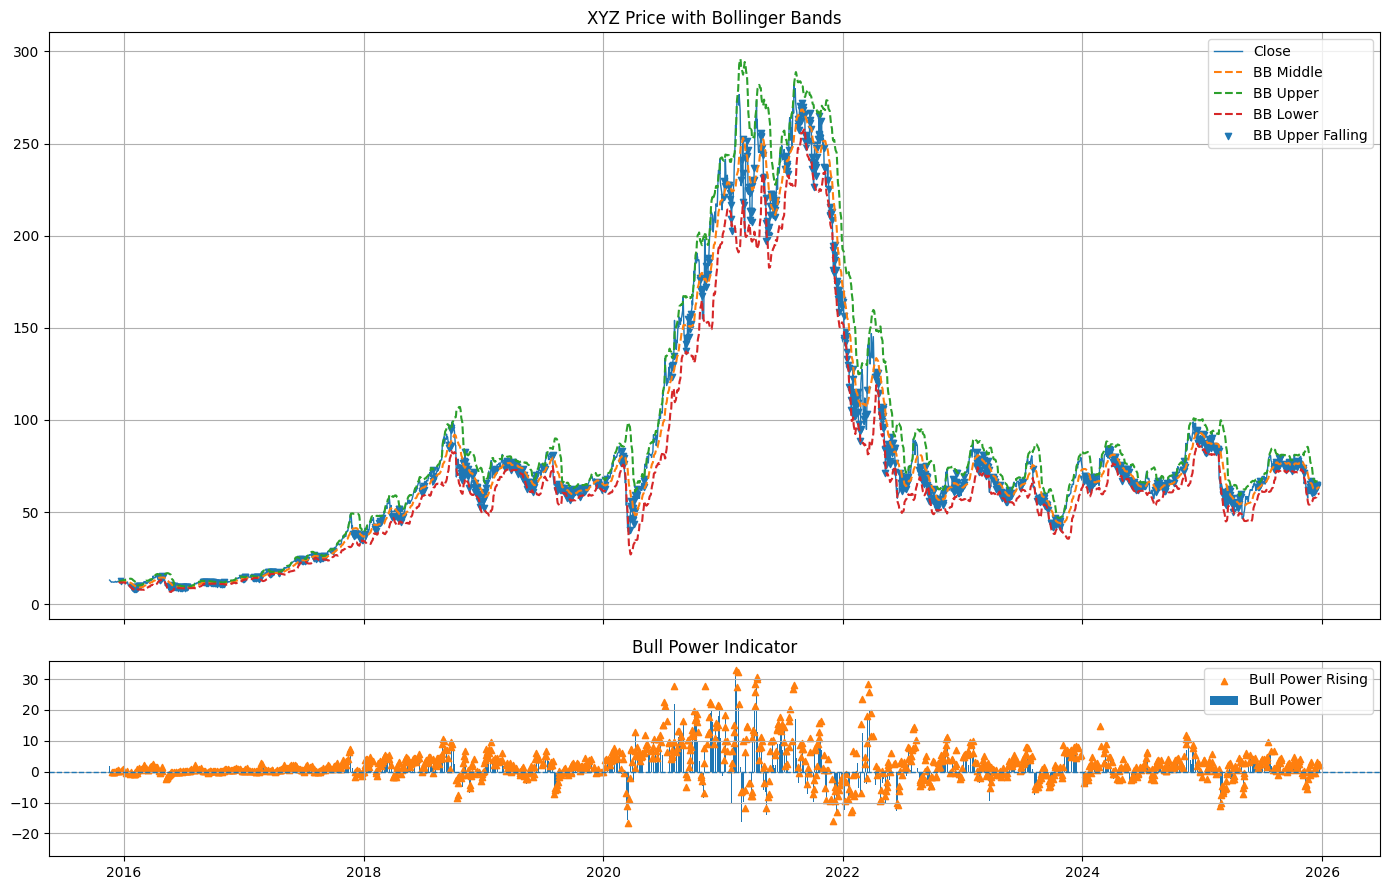

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "XYZ"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df = df.dropna()

# -------------------------
# Parameters
# -------------------------
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
BULL_EMA_PERIOD = 13

# -------------------------
# Indicator Calculations
# -------------------------

# EMA
df["EMA"] = df["Close"].ewm(span=BULL_EMA_PERIOD, adjust=False).mean()

# Bull Power
df["Bull_Power"] = df["High"] - df["EMA"]
df["Bull_Power_Rising"] = df["Bull_Power"].diff() > 0

# Bollinger Bands
df["BB_MA"] = df["Close"].rolling(BB_PERIOD).mean()
df["BB_STD"] = df["Close"].rolling(BB_PERIOD).std()
df["BB_Upper"] = df["BB_MA"] + BB_STD * df["BB_STD"]
df["BB_Lower"] = df["BB_MA"] - BB_STD * df["BB_STD"]

# Upper Band Falling Condition
df["BB_Upper_Falling"] = df["BB_Upper"] < df["BB_Upper"].shift(BB_SHIFT)

# -------------------------
# Plotting
# -------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14, 9), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# ===== Price + Bollinger Bands =====
ax1.plot(df.index, df["Close"], label="Close", linewidth=1)
ax1.plot(df.index, df["BB_MA"], linestyle="--", label="BB Middle")
ax1.plot(df.index, df["BB_Upper"], linestyle="--", label="BB Upper")
ax1.plot(df.index, df["BB_Lower"], linestyle="--", label="BB Lower")

# Highlight BB Upper Falling
ax1.scatter(
    df.index[df["BB_Upper_Falling"]],
    df["Close"][df["BB_Upper_Falling"]],
    marker="v",
    s=20,
    label="BB Upper Falling"
)

ax1.set_title(f"{symbol} Price with Bollinger Bands")
ax1.legend()
ax1.grid(True)

# ===== Bull Power =====
ax2.bar(
    df.index,
    df["Bull_Power"],
    label="Bull Power"
)

# Highlight Bull Power Rising
ax2.scatter(
    df.index[df["Bull_Power_Rising"]],
    df["Bull_Power"][df["Bull_Power_Rising"]],
    marker="^",
    s=20,
    label="Bull Power Rising"
)

ax2.axhline(0, linestyle="--", linewidth=1)
ax2.set_title("Bull Power Indicator")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
